# Prediction Modeling

- 데이터분석을 실시했던 Kaggle의 Hotel booking 데이터로 예측모델링 실시

## 배경

- 현재 마케팅부서에서 호텔 예약 건수를 늘리기 위한 추가적인 마케팅 전략을 수립하려고 함. 새로운 마케팅전략에 근간이 되는 인사이트를 데이터로부터 도출 요청.

- 데이터분석 리포팅에서 설정했던 '예약 취소하는 사람들의 특성' 가설을 기반으로 데이터에서 호텔을 예약하는 사람들의 여러가지 특징(feature)들로 이 사람의 예약 취소 여부(binary)를 예측하는 모델을 구현하려 함.

## 목적

- 호텔을 최초로 예약할 때의 특징들을 독립변수들로 하여 추후 예약 취소 여부를 예측
- 취소로 예측된 예약들의 공통된 특성을 파악하고 이를 마케팅 부서에게 전달

## 가설

- 사전에 실시한 데이터 분석으로 보증금 유형이 Non-Refund이면서 market_segment가 Groups나 Offline TA/TO일 때 예약 취소 가능성이 높았음을 도출. 따라서 deposit_type과 market_segment가 여러 중요한 변수 중 일부일 것이라고 판단


## 데이터 전처리

In [1]:
# 데이터로드
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data')
hotel = pd.read_csv('hotel_bookings.csv', encoding='utf-8')
hotel.shape

(119390, 32)

- 결측치가 있는 변수들
    * agent : 예약을 대행한 여행업체의 ID
    * company : 예약을 한 기업의 ID(익명화 처리됨)
    * country : 예약한 투숙객의 국적
    * children : 예약한 투숙객의 아이들 수
- 하지만 결측치가 있는 변수들 중 agent, company, country는 우리가 설정한 문제를 해결하는 데 유용하지 않은 변수이다.
- children은 결측치가 4개 이므로 해당 결측치를 0으로 대체해도 무방

In [3]:
# 결측치가 존재하는 변수들 삭제
hotel = hotel.drop(['agent','company','country'], axis=1)
hotel['children'] = hotel['children'].fillna(0)
hotel.isnull().sum().sum()

0

In [4]:
# data type을 보고 int, float형으로 되어있어야하는 변수 type이 object로 되어있다면 ' '와 같은 공백 문자열이 결측치로 들어가 있을 가능성 체크
hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
days_in_waiting_list                int64
customer_type                     

In [5]:
# 의심가는 변수 : arrival_date_month 확인해보자 -> month가 문자열로 되어있음 
hotel['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [6]:
# 문자열 month를 숫자형으로 mapping
month_dict = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,
             'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6}
hotel['arrival_date_month'] = hotel['arrival_date_month'].map(month_dict)
hotel['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

In [29]:
# 이상치 처리하기
# 수치형 변수들 기초통계량 살펴보기(날짜관련 변수, 취소여부 변수 제외)
numeric_cols = pd.Series(hotel.dtypes[hotel.dtypes != 'object'].index)
numeric_cols = numeric_cols[~numeric_cols.str.contains('date|cancel|nights')].values
print(numeric_cols)

['lead_time' 'adults' 'children' 'babies' 'is_repeated_guest'
 'booking_changes' 'days_in_waiting_list' 'adr'
 'required_car_parking_spaces' 'total_of_special_requests']


In [33]:
# 추출한 변수들로 기초통계량 살펴보기
hotel[numeric_cols].describe()

,lead_time,adults,children,babies,is_repeated_guest,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,104.011416,1.856403,0.103886,0.007949,0.031912,0.221124,2.321149,101.831122,0.062518,0.571363
std,106.863097,0.579261,0.398555,0.097436,0.175767,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,18.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,69.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,160.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,737.000000,55.000000,10.000000,10.000000,1.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


- adr : 숙박 예약의 총 합을 숙박 일수의 총 합으로 나눈 일일 비율로 예측모델링에는 필요하지 않은 변수로 예상되어 이상치 탐지 안 함.
-  lead_time, adults, days_in_waiting_list 이렇게 3개의 변수가 이상치가 있는 것으로 판단이 되지만 무조건적으로 제거하면 안 됨.
-  이상치들의 정확한 존재 이유를 파악하고 제거를 하거나 유지하고 scaling을 해줄지 결정해야 함

In [60]:
# lead_time 이상치 파악
# lead_time 값의 종류들 살펴보기 -> 의외로 몇백일 단위의 값들이 많다.. 이상치 제거할 필요보단 정규화시켜주어야 할 듯 싶다.
hotel['lead_time'].unique()

array([342, 737,   7,  13,  14,   0,   9,  85,  75,  23,  35,  68,  18,
        37,  12,  72, 127,  78,  48,  60,  77,  99, 118,  95,  96,  69,
        45,  40,  15,  36,  43,  70,  16, 107,  47, 113,  90,  50,  93,
        76,   3,   1,  10,   5,  17,  51,  71,  63,  62, 101,   2,  81,
       368, 364, 324,  79,  21, 109, 102,   4,  98,  92,  26,  73, 115,
        86,  52,  29,  30,  33,  32,   8, 100,  44,  80,  97,  64,  39,
        34,  27,  82,  94, 110, 111,  84,  66, 104,  28, 258, 112,  65,
        67,  55,  88,  54, 292,  83, 105, 280, 394,  24, 103, 366, 249,
        22,  91,  11, 108, 106,  31,  87,  41, 304, 117,  59,  53,  58,
       116,  42, 321,  38,  56,  49, 317,   6,  57,  19,  25, 315, 123,
        46,  89,  61, 312, 299, 130,  74, 298, 119,  20, 286, 136, 129,
       124, 327, 131, 460, 140, 114, 139, 122, 137, 126, 120, 128, 135,
       150, 143, 151, 132, 125, 157, 147, 138, 156, 164, 346, 159, 160,
       161, 333, 381, 149, 154, 297, 163, 314, 155, 323, 340, 35

<AxesSubplot:>

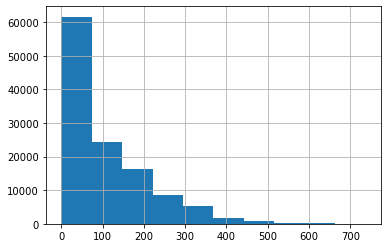

In [61]:
# 값들 분포 확인하기
hotel['lead_time'].hist()

In [ ]:
# 정규화시키기